In [46]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno

from scipy.stats import shapiro

from scipy import stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import matthews_corrcoef

import seaborn as sns
import re

import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

In [3]:
%load_ext autoreload
%autoreload 2
from help_tool import help_tool

# Data download and Cleaning

In [150]:
stroke_prediction=help_tool.csv_download(r"C:\Users\Gintare\Desktop\Study\Module3\Sprint2\Code\archive\healthcare-dataset-stroke-data.csv")
stroke_prediction.head()

,Id,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
help_tool.first_look(stroke_prediction)

Column data types:
Id                     int64
Gender                object
Age                  float64
Hypertension           int64
Heart_disease          int64
Ever_married          object
Work_type             object
Residence_type        object
Avg_glucose_level    float64
Bmi                  float64
Smoking_status        object
Stroke                 int64
dtype: object

Dataset has 5110 observations and 12 features
Columns with NULL values: ['Bmi']
Dataset has 0 duplicates


In [7]:
stroke_prediction['Age']=stroke_prediction['Age'].astype(int)

In [11]:
continues_features=['Age', 'Avg_glucose_level', 'Bmi']
category_features=['Gender', 'Hypertension', 'Heart_disease', 'Ever_married', 'Work_type', 'Residence_type', 'Smoking_status', 'Stroke']

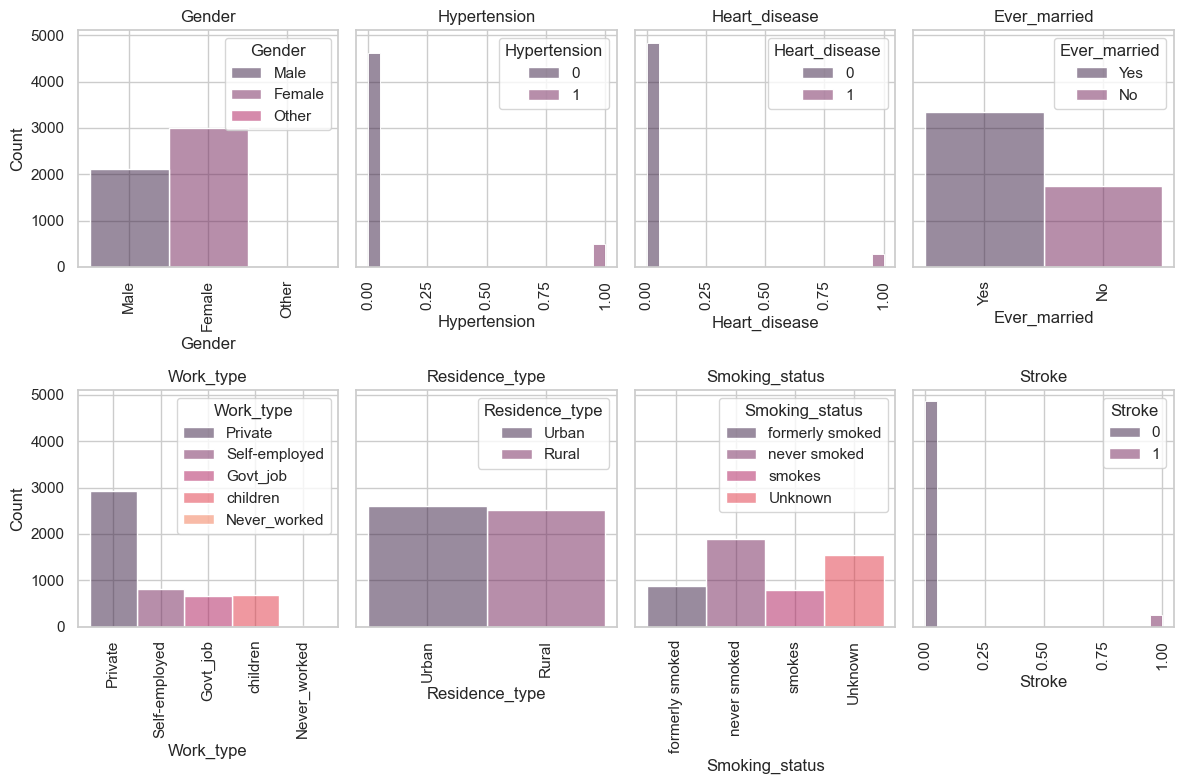

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8), sharey=True)

# Flatten axes since we have a 2x4 grid
axes = axes.flatten()

for i, col in enumerate(category_features):
    sns.histplot(data=stroke_prediction, x=col, kde=True, bins=20,
                    ax=axes[i], hue=col, legend=True)
    axes[i].set_title(col)  # Set title for each subplot
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

In [13]:
for i in category_features:
    print(stroke_prediction[i].value_counts())

Female    2994
Male      2115
Other        1
Name: Gender, dtype: int64
0    4612
1     498
Name: Hypertension, dtype: int64
0    4834
1     276
Name: Heart_disease, dtype: int64
Yes    3353
No     1757
Name: Ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: Work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: Smoking_status, dtype: int64
0    4861
1     249
Name: Stroke, dtype: int64


* 1 person with Gender 'Other'
* 22 never worked and 687 is 'children'

who are these people?
* non binary representation is 1 person and this row will be dropped

In [144]:
stroke_prediction[stroke_prediction['Gender']=='Other']

,Id,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke
3116,56156,Other,26,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [271]:
stroke_data=stroke_prediction[stroke_prediction['Gender']!='Other']
stroke_data.drop(columns=['Id'], inplace=True)

C:\Users\Gintare\AppData\Local\Temp\ipykernel_12740\3942284780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke_data.drop(columns=['Id'], inplace=True)


In [272]:
stroke_data = help_tool.dummy_columns(stroke_data, ['Gender', 'Ever_married', 'Residence_type'])
stroke_data.rename(columns={'Residence_type_Urban':'Residence_Urban'}, inplace=True)
stroke_data.drop(columns=['Gender_Male', 'Residence_type_Rural'], inplace=True)

Adults and children (up to 17 years old) have different ranking of BMI (Body Mass index) 

Adults https://blog.skinnyfit.com/wp-content/uploads/2021/01/shutterstock_1610175649-2048x2048.jpg

Children https://dryatendrayadav.com/wp-content/uploads/2018/10/Sample-BMI-interpretation.jpg 

However, childrens BMI is generaly lower than adults and children BMI tolerance represent a parabole. For children categorization a mark for 10 years have been choosen to rougthly represent children BMI categories.

In [273]:
stroke_data = duckdb.query("""
             SELECT * 
                ,CASE 
                    WHEN Age >= 17 AND Bmi < 19.0 THEN 1 -- Underweight
                    WHEN Age >= 17 AND Bmi BETWEEN 19 AND 25 THEN 2 -- Healthy
                    WHEN Age >= 17 AND Bmi BETWEEN 25 AND 30 THEN 3 -- Overweight
                    WHEN Age >= 17 AND Bmi BETWEEN 30 AND 40 THEN 4 -- Obese
                    WHEN Age >= 17 AND Bmi >= 40 THEN 5 -- Extremely Obese

                    WHEN Age < 17 AND Bmi < 14.0 THEN 1 -- Underweight
                    WHEN Age < 17 AND Bmi BETWEEN 14 AND 19 THEN 2 -- Healthy
                    WHEN Age < 17 AND Bmi BETWEEN 19 AND 22 THEN 3 -- Overweight
                    WHEN Age < 17 AND Bmi >= 22 THEN 4 -- Obese
                             
                END AS BMI_category
             FROM stroke_data
""").to_df()

#stroke_data['BMI_category']=stroke_data['BMI_category'].astype(int)

In [229]:
category_features=['Gender_Female', 'Hypertension', 'Heart_disease', 'Ever_married', 'Work_type', 'Residence_Urban', 'Smoking_status', 'Stroke', 'BMI_category']

In [230]:
help_tool.first_look(stroke_data)

Column data types:
Age                  float64
Hypertension           int64
Heart_disease          int64
Work_type             object
Avg_glucose_level    float64
Bmi                  float64
Smoking_status        object
Stroke                 int64
Gender_Female          int32
Ever_married           int32
Residence_Urban        int32
BMI_category         float64
dtype: object

Dataset has 5109 observations and 12 features
Columns with NULL values: ['Bmi', 'BMI_category']
Dataset has 0 duplicates


Age


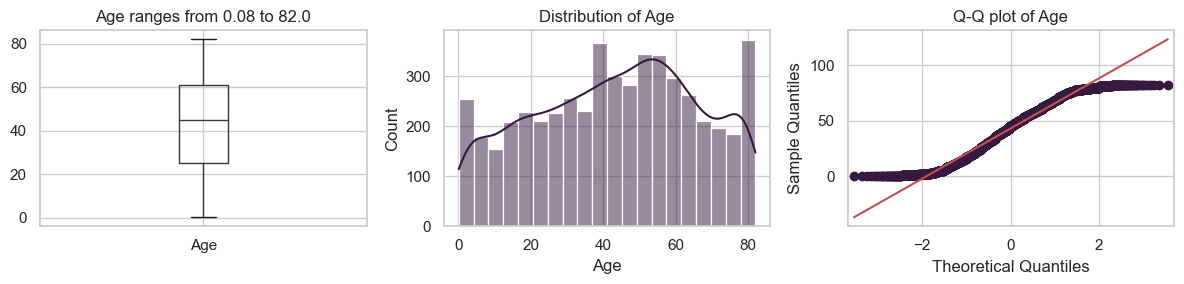

Avg_glucose_level


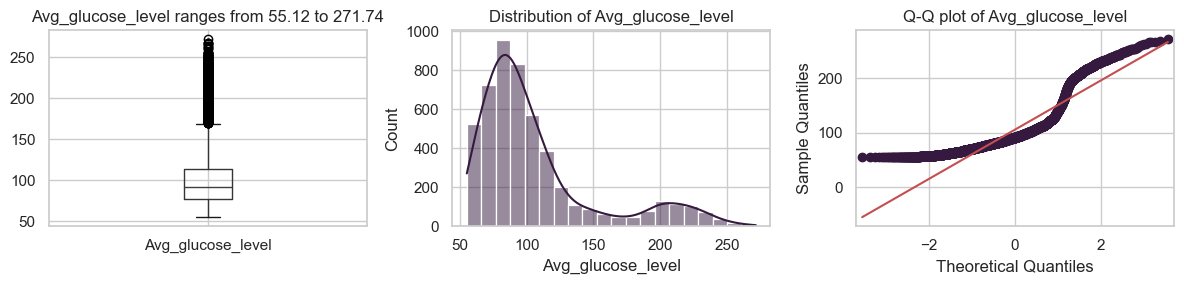

Bmi


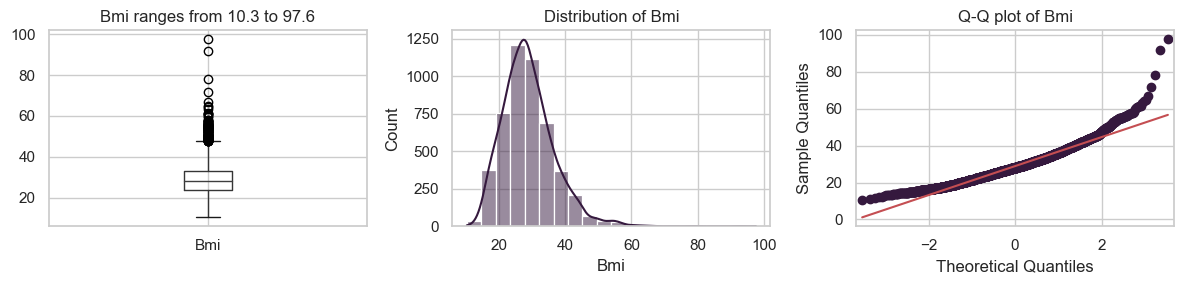

BMI_category


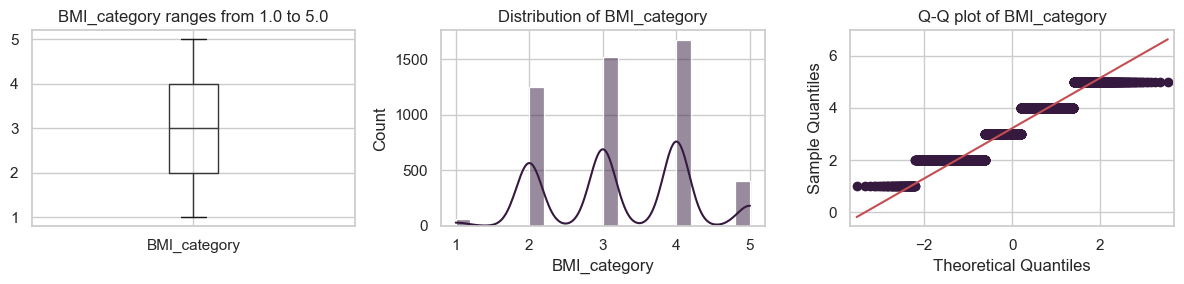

In [231]:
help_tool.distribution_check(
    stroke_data[['Age', 'Avg_glucose_level', 'Bmi', 'BMI_category']])

Age cleaning

IndexError: index 5 is out of bounds for axis 0 with size 5

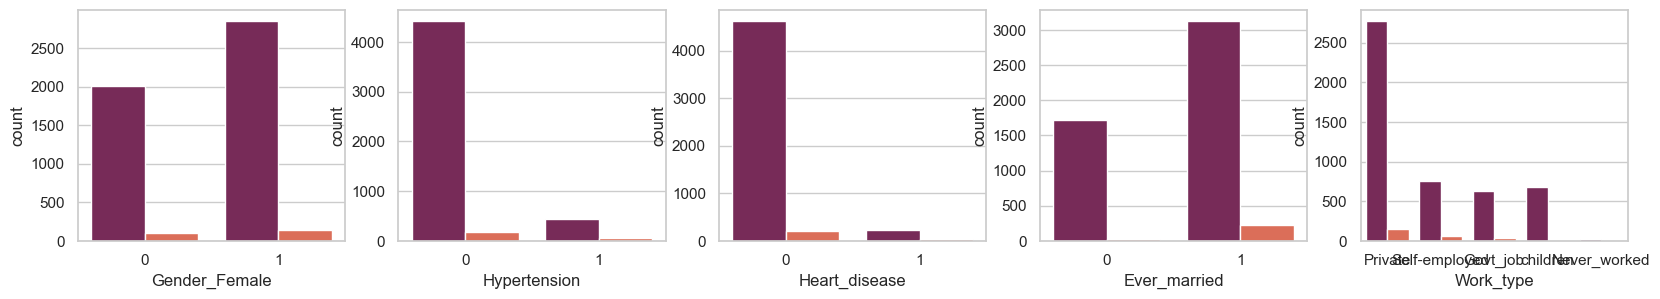

In [42]:
help_tool.countplot_per_feature(stroke_data, category_features, hue='Stroke')

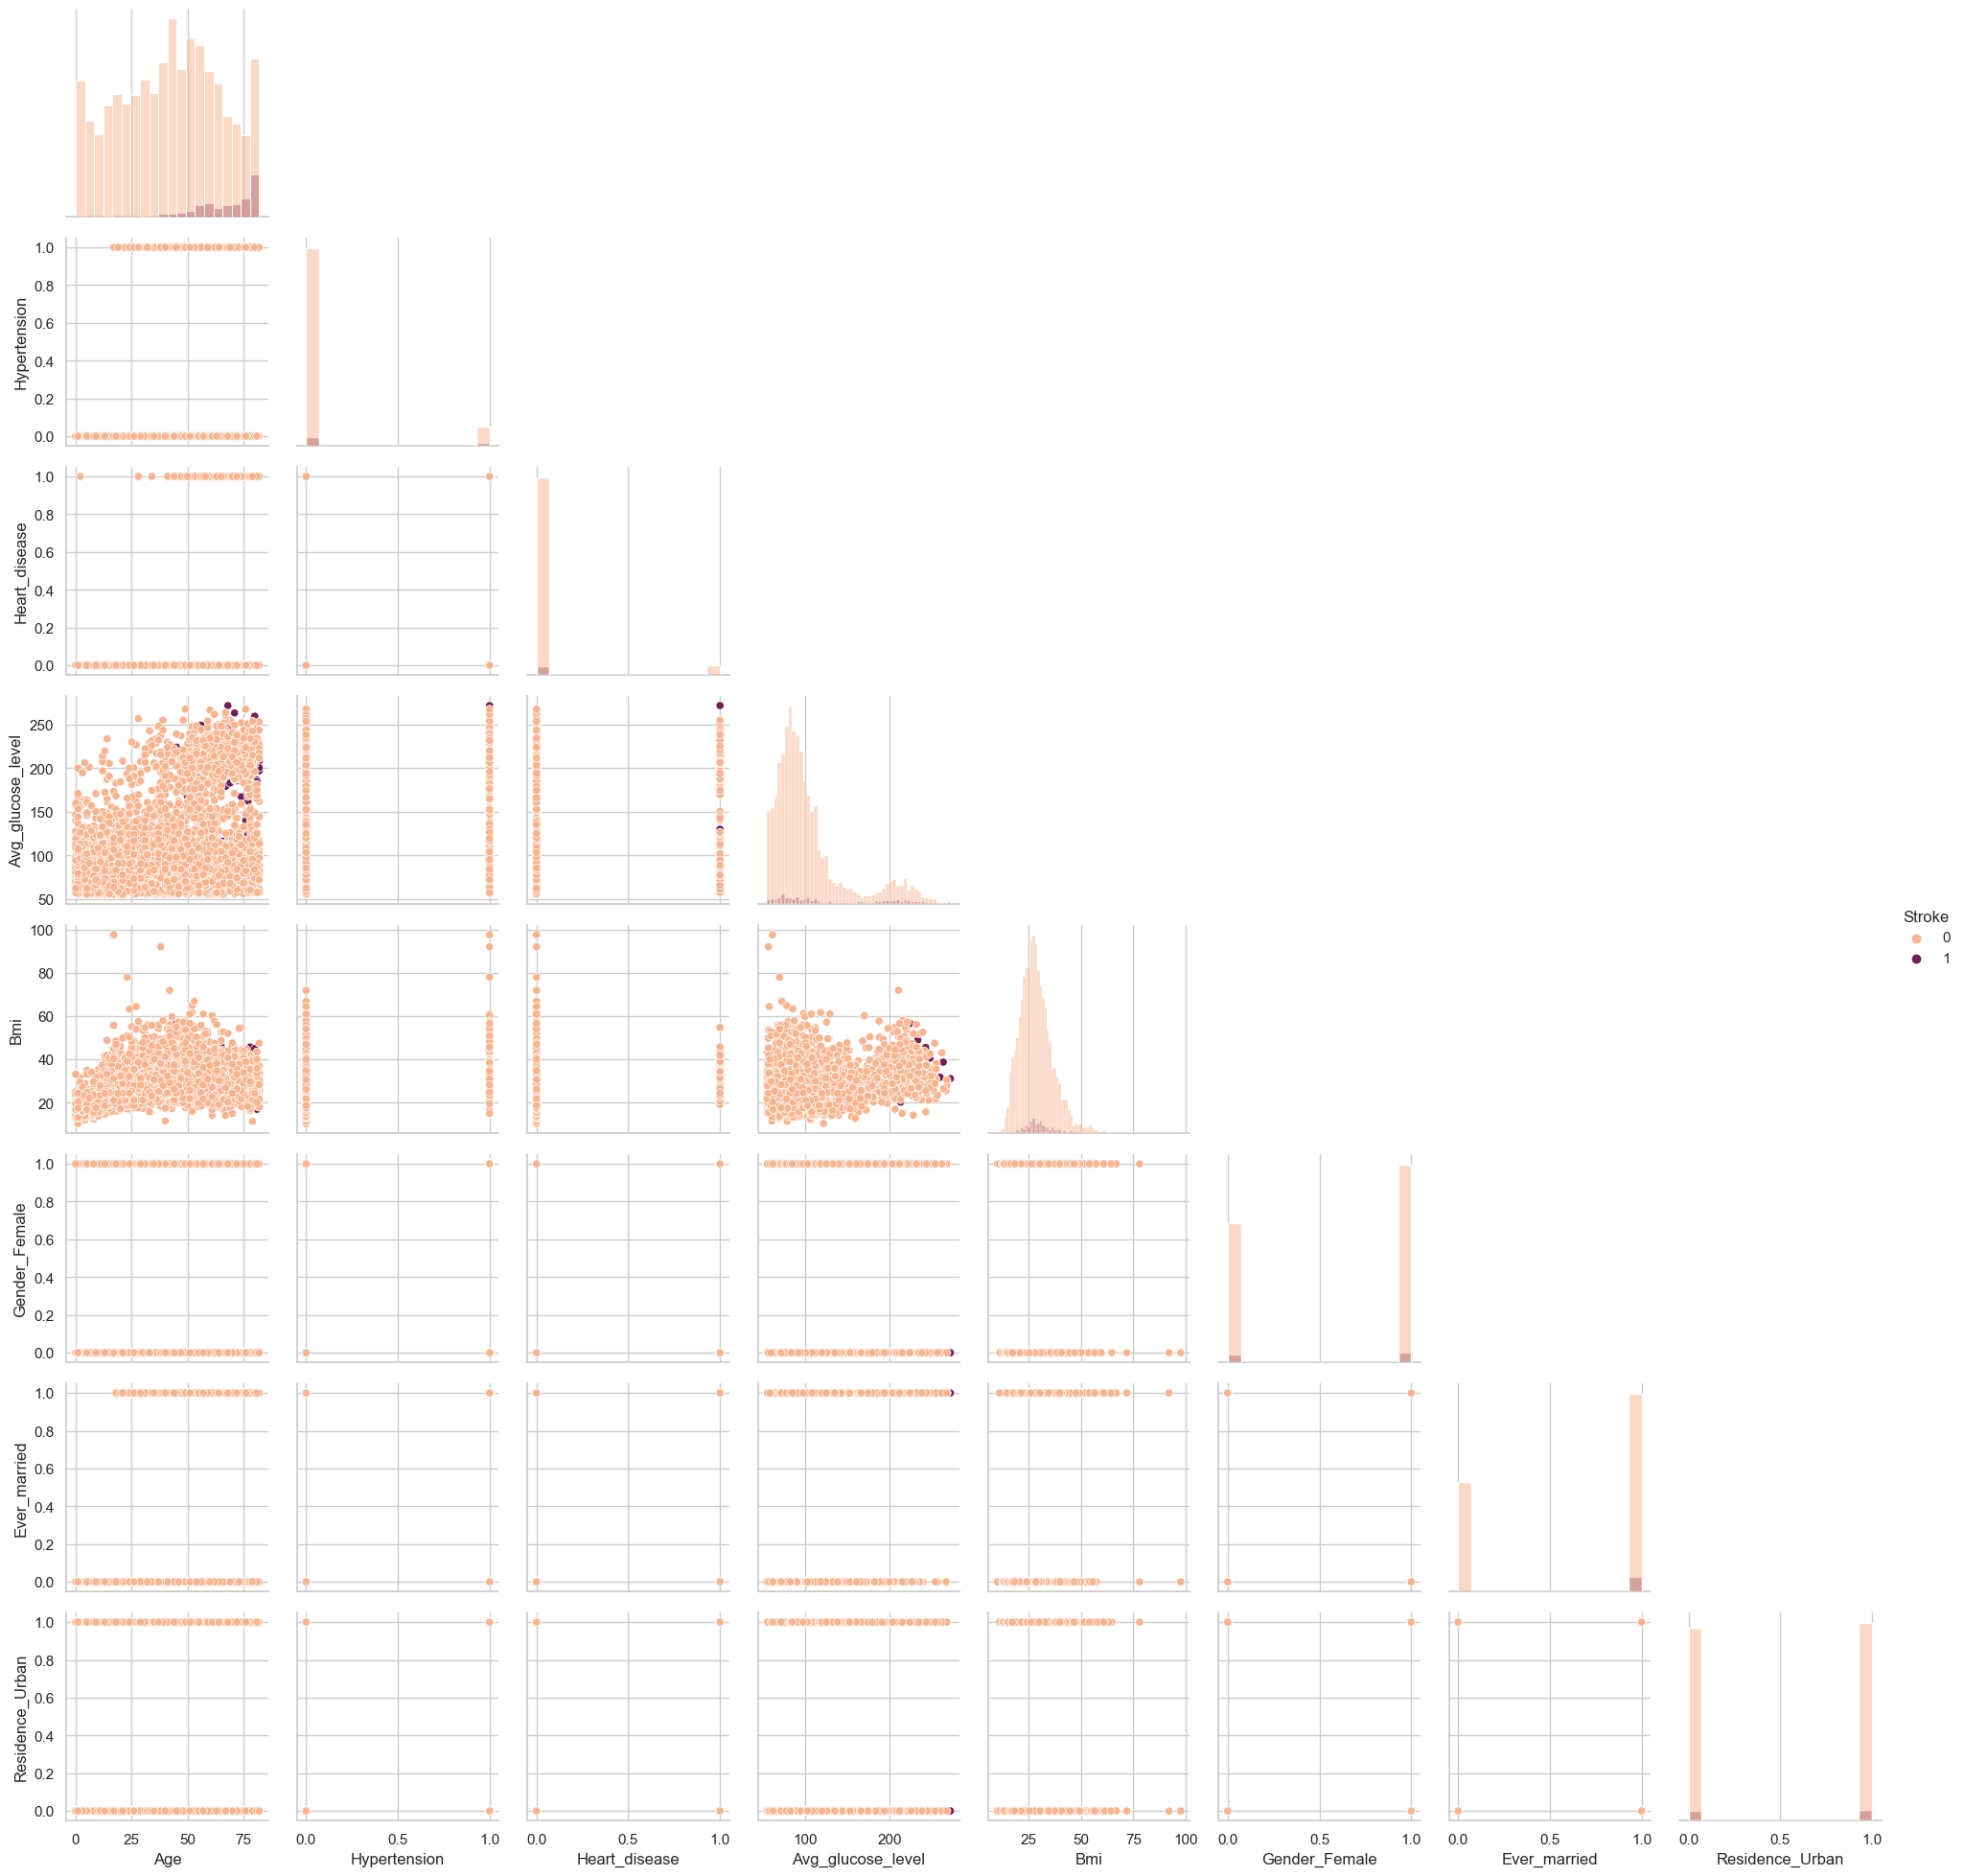

In [43]:
g = sns.PairGrid(stroke_data,
                 hue='Stroke',
                 diag_sharey=False, corner=True,
                 palette={1: 'C1', 0: 'C5'}
                 )
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

plt.show()

### BMI

In [232]:
stroke_data[stroke_data['Bmi']>65]

,Age,Hypertension,Heart_disease,Work_type,Avg_glucose_level,Bmi,Smoking_status,Stroke,Gender_Female,Ever_married,Residence_Urban,BMI_category
544,42.0,0,0,Private,210.48,71.9,never smoked,0,0,1,0,5.0
928,23.0,1,0,Private,70.03,78.0,smokes,0,1,0,1,5.0
1559,53.0,0,0,Private,72.63,66.8,Unknown,0,1,1,0,5.0
2128,17.0,1,0,Private,61.67,97.6,Unknown,0,0,0,0,5.0
4208,38.0,1,0,Private,56.90,92.0,never smoked,0,0,1,0,5.0


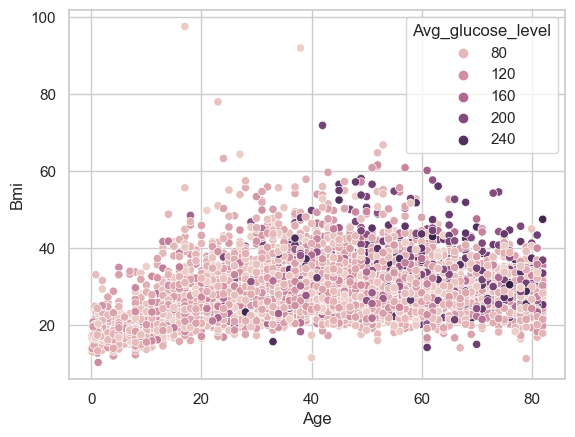

In [166]:
sns.scatterplot(stroke_data, x='Age', y='Bmi', hue='Avg_glucose_level')
plt.show()

In [239]:
stroke_data.drop(stroke_data[stroke_data['Bmi'] > 65].index, inplace=True)

### Corr

C:\Users\Gintare\AppData\Local\Temp\ipykernel_12740\2251319465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(stroke_data.corr(method='pearson'),


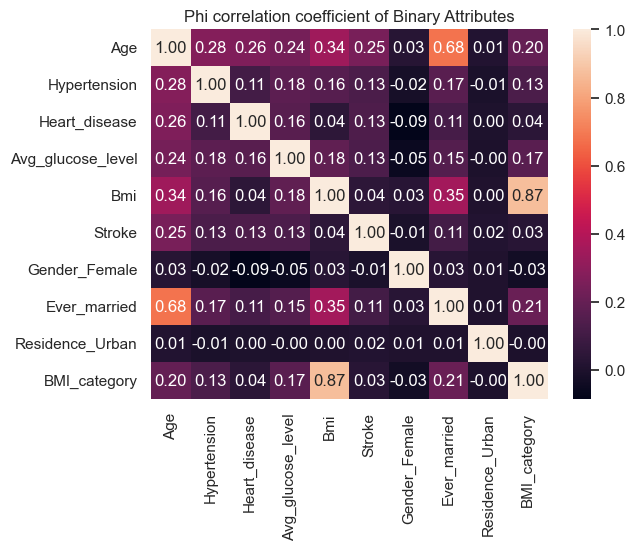

In [240]:
sns.heatmap(stroke_data.corr(method='pearson'),
            annot=True, cmap='rocket', fmt=".2f")
plt.title(f'Phi correlation coefficient of Binary Attributes')
plt.show()

In [60]:
phi_corr_matrix = pd.DataFrame(index=category_features, columns=category_features)

for feature1 in category_features:
    for feature2 in category_features:
        phi_corr_matrix.loc[feature1, feature2] = matthews_corrcoef(
            stroke_data[feature1], stroke_data[feature2])

sns.heatmap(phi_corr_matrix.astype(float),
            annot=True, cmap='rocket', fmt=".2f")
plt.title(f'Phi correlation coefficient of Binary Attributes')
plt.show()

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [167]:
stroke_data=stroke_prediction[stroke_prediction['Gender']!='Other']
stroke_data.drop(columns=['Id'], inplace=True)

stroke_data = help_tool.dummy_columns(stroke_data, ['Gender', 'Ever_married', 'Residence_type'])
stroke_data.rename(columns={'Residence_type_Urban':'Residence_Urban'}, inplace=True)
stroke_data.drop(columns=['Gender_Male', 'Residence_type_Rural'], inplace=True)

C:\Users\Gintare\AppData\Local\Temp\ipykernel_12740\3781249144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke_data.drop(columns=['Id'], inplace=True)


# Cleaning
## Unknown smoking status vs Work_type
### Children
Work_type vs Smoking_status: Sometimes questions are not answered due to not being applicable. I.e., asking a small child if they ever smoked.

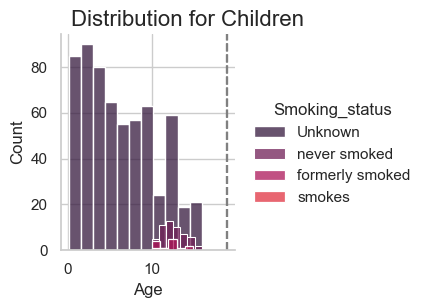

In [242]:
g = sns.FacetGrid(stroke_data[stroke_data['Work_type'] == 'children'], hue="Smoking_status", margin_titles=True)
g.map_dataframe(sns.histplot, x='Age', multiple="stack", common_norm=True, element='bars', stat='count')
g.refline(x=19)

g.add_legend()
g.figure.suptitle(f"Distribution for Children", size=16, y=1.02)
plt.show()

In [243]:
stroke_data[stroke_data['Work_type'] == 'children']['Age'].max()

16.0

Children work type is categorized as people under 16 years old. Children unknown data will be recategorized to 'never smoked'

In [244]:
stroke_data.loc[(stroke_data['Smoking_status'] == 'Unknown') & (stroke_data['Work_type'] == 'children'), 'Smoking_status'] = 'never smoked'

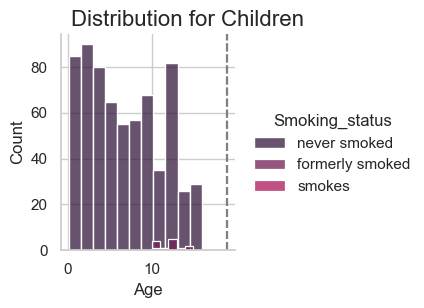

In [245]:
g = sns.FacetGrid(stroke_data[stroke_data['Work_type'] == 'children'], hue="Smoking_status", margin_titles=True)
g.map_dataframe(sns.histplot, x='Age', multiple="stack", common_norm=True, element='bars', stat='count')
g.refline(x=19)

g.add_legend()
g.figure.suptitle(f"Distribution for Children", size=16, y=1.02)
plt.show()

### Never Worked
Never worked individuals overlap with childer (<16 years old) and extend to 19 years old (year of finishing high school). It's not uncommon for people in school to be considered chilred and not work.

Peple under 19 years will be recategorized to 'never smoked' from 'unknown'

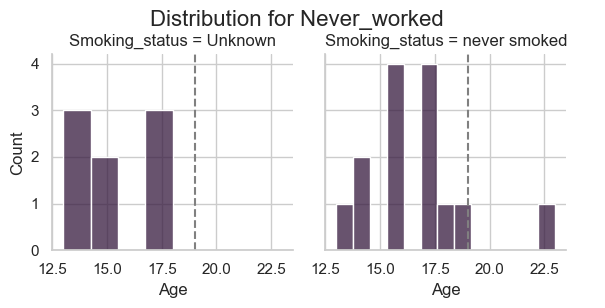

In [246]:
g = sns.FacetGrid(stroke_data[stroke_data['Work_type'] == 'Never_worked'], col="Smoking_status", margin_titles=True)
g.map_dataframe(sns.histplot, x='Age', multiple="stack",
                common_norm=True, element='bars', stat='count')
g.refline(x=19)

g.add_legend()
g.figure.suptitle(f"Distribution for Never_worked", size=16, y=1.02)
plt.show()

In [248]:
stroke_data[stroke_data['Work_type'] == 'Never_worked']['Smoking_status'].value_counts()

never smoked    14
Unknown          8
Name: Smoking_status, dtype: int64

In [249]:
stroke_data[(stroke_data['Smoking_status'] == 'Unknown') & (stroke_data['Work_type'] == 'Never_worked')]

,Age,Hypertension,Heart_disease,Work_type,Avg_glucose_level,Bmi,Smoking_status,Stroke,Gender_Female,Ever_married,Residence_Urban,BMI_category
253,14.0,0,0,Never_worked,161.28,19.1,Unknown,0,0,0,0,3.0
939,13.0,0,0,Never_worked,111.48,20.8,Unknown,0,0,0,0,3.0
1462,17.0,0,0,Never_worked,61.01,32.5,Unknown,0,0,0,0,4.0
2740,15.0,0,0,Never_worked,79.59,28.4,Unknown,0,0,0,0,4.0
2917,18.0,0,0,Never_worked,82.36,22.7,Unknown,0,1,0,1,2.0
3971,15.0,0,0,Never_worked,64.29,16.7,Unknown,0,0,0,1,2.0
4409,13.0,0,0,Never_worked,85.08,14.6,Unknown,0,0,0,1,2.0
4771,18.0,0,0,Never_worked,97.65,21.5,Unknown,0,1,0,1,2.0


In [250]:
#stroke_data.loc[(stroke_data['Smoking_status'] == 'Unknown') & (stroke_data['Work_type'] == 'Never_worked'), 'Smoking_status'] = 'never smoked'
stroke_data.loc[(stroke_data['Work_type'] == 'children'), 'Work_type'] = 'Never_worked'

### Other

In [251]:
stroke_data[(stroke_data['Smoking_status'] == 'Unknown')]

,Age,Hypertension,Heart_disease,Work_type,Avg_glucose_level,Bmi,Smoking_status,Stroke,Gender_Female,Ever_married,Residence_Urban,BMI_category
8,59.0,0,0,Private,76.15,NaN,Unknown,1,1,1,0,NaN
9,78.0,0,0,Private,58.57,24.2,Unknown,1,1,1,1,2.0
13,78.0,0,1,Private,219.84,NaN,Unknown,1,0,1,1,NaN
19,57.0,0,1,Govt_job,217.08,NaN,Unknown,1,0,0,1,NaN
23,82.0,0,1,Private,208.30,32.5,Unknown,1,0,1,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5087,64.0,1,0,Self-employed,76.89,30.2,Unknown,0,1,1,1,4.0
5096,68.0,0,0,Self-employed,91.68,40.8,Unknown,0,0,1,1,5.0
5100,45.0,0,0,Private,97.95,24.5,Unknown,0,1,1,1,2.0
5102,18.0,0,0,Private,82.85,46.9,Unknown,0,1,0,1,5.0


### BMI

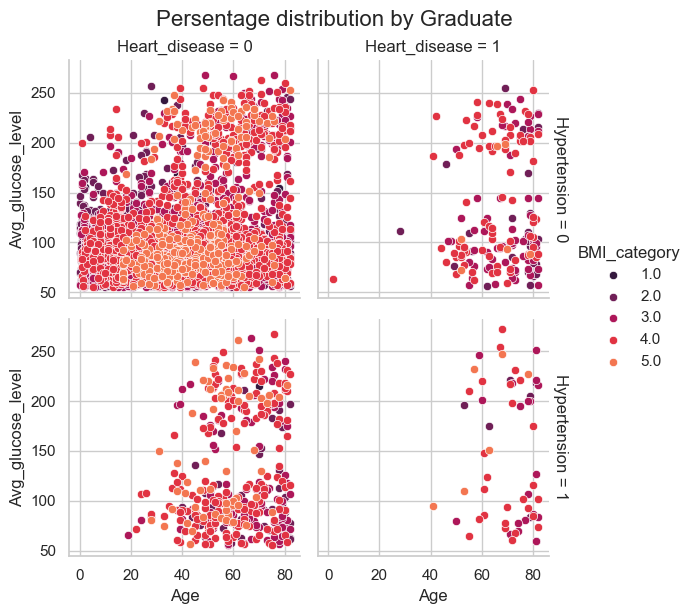

In [255]:
g = sns.FacetGrid(stroke_data[~stroke_data['Bmi'].isna()], col="Heart_disease", row='Hypertension', hue='BMI_category', margin_titles=True)
g.map_dataframe(sns.scatterplot, x='Age', y='Avg_glucose_level')
g.add_legend()
g.figure.suptitle(f"Persentage distribution by Graduate", size=16, y=1.02)
plt.show()

In [258]:
stroke_data.columns

Index(['Age', 'Hypertension', 'Heart_disease', 'Work_type',
       'Avg_glucose_level', 'Bmi', 'Smoking_status', 'Stroke', 'Gender_Female',
       'Ever_married', 'Residence_Urban', 'BMI_category'],
      dtype='object')

### KNN for BMI

In [301]:
from sklearn.cluster import KMeans

df = help_tool.dummy_columns(stroke_data, ['Work_type', 'Smoking_status'])

In [302]:
df.columns

Index(['Age', 'Hypertension', 'Heart_disease', 'Avg_glucose_level', 'Bmi',
       'Stroke', 'Gender_Female', 'Ever_married', 'Residence_Urban',
       'BMI_category', 'Work_type_Govt_job', 'Work_type_Never_worked',
       'Work_type_Private', 'Work_type_Self-employed', 'Work_type_children',
       'Smoking_status_Unknown', 'Smoking_status_formerly smoked',
       'Smoking_status_never smoked', 'Smoking_status_smokes'],
      dtype='object')

In [299]:
X = df.copy()
y = X.pop("Bmi")

In [303]:
X_scaled = X
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [292]:
df.columns

Index(['Age', 'Hypertension', 'Heart_disease', 'Avg_glucose_level', 'Stroke',
       'Gender_Female', 'Ever_married', 'Residence_Urban', 'BMI_category',
       'Work_type_Govt_job', 'Work_type_Never_worked', 'Work_type_Private',
       'Work_type_Self-employed', 'Work_type_children',
       'Smoking_status_Unknown', 'Smoking_status_formerly smoked',
       'Smoking_status_never smoked', 'Smoking_status_smokes'],
      dtype='object')

In [293]:
Xy.melt(value_vars=df.columns, id_vars=["BMI_category", "Cluster"],)

,BMI_category,Cluster,variable,value
0,4.0,7,Age,67.0
1,NaN,8,Age,61.0
2,4.0,7,Age,80.0
3,4.0,8,Age,49.0
4,2.0,8,Age,79.0
...,...,...,...,...
86848,NaN,3,Smoking_status_smokes,0.0
86849,4.0,4,Smoking_status_smokes,0.0
86850,4.0,4,Smoking_status_smokes,0.0
86851,3.0,2,Smoking_status_smokes,0.0


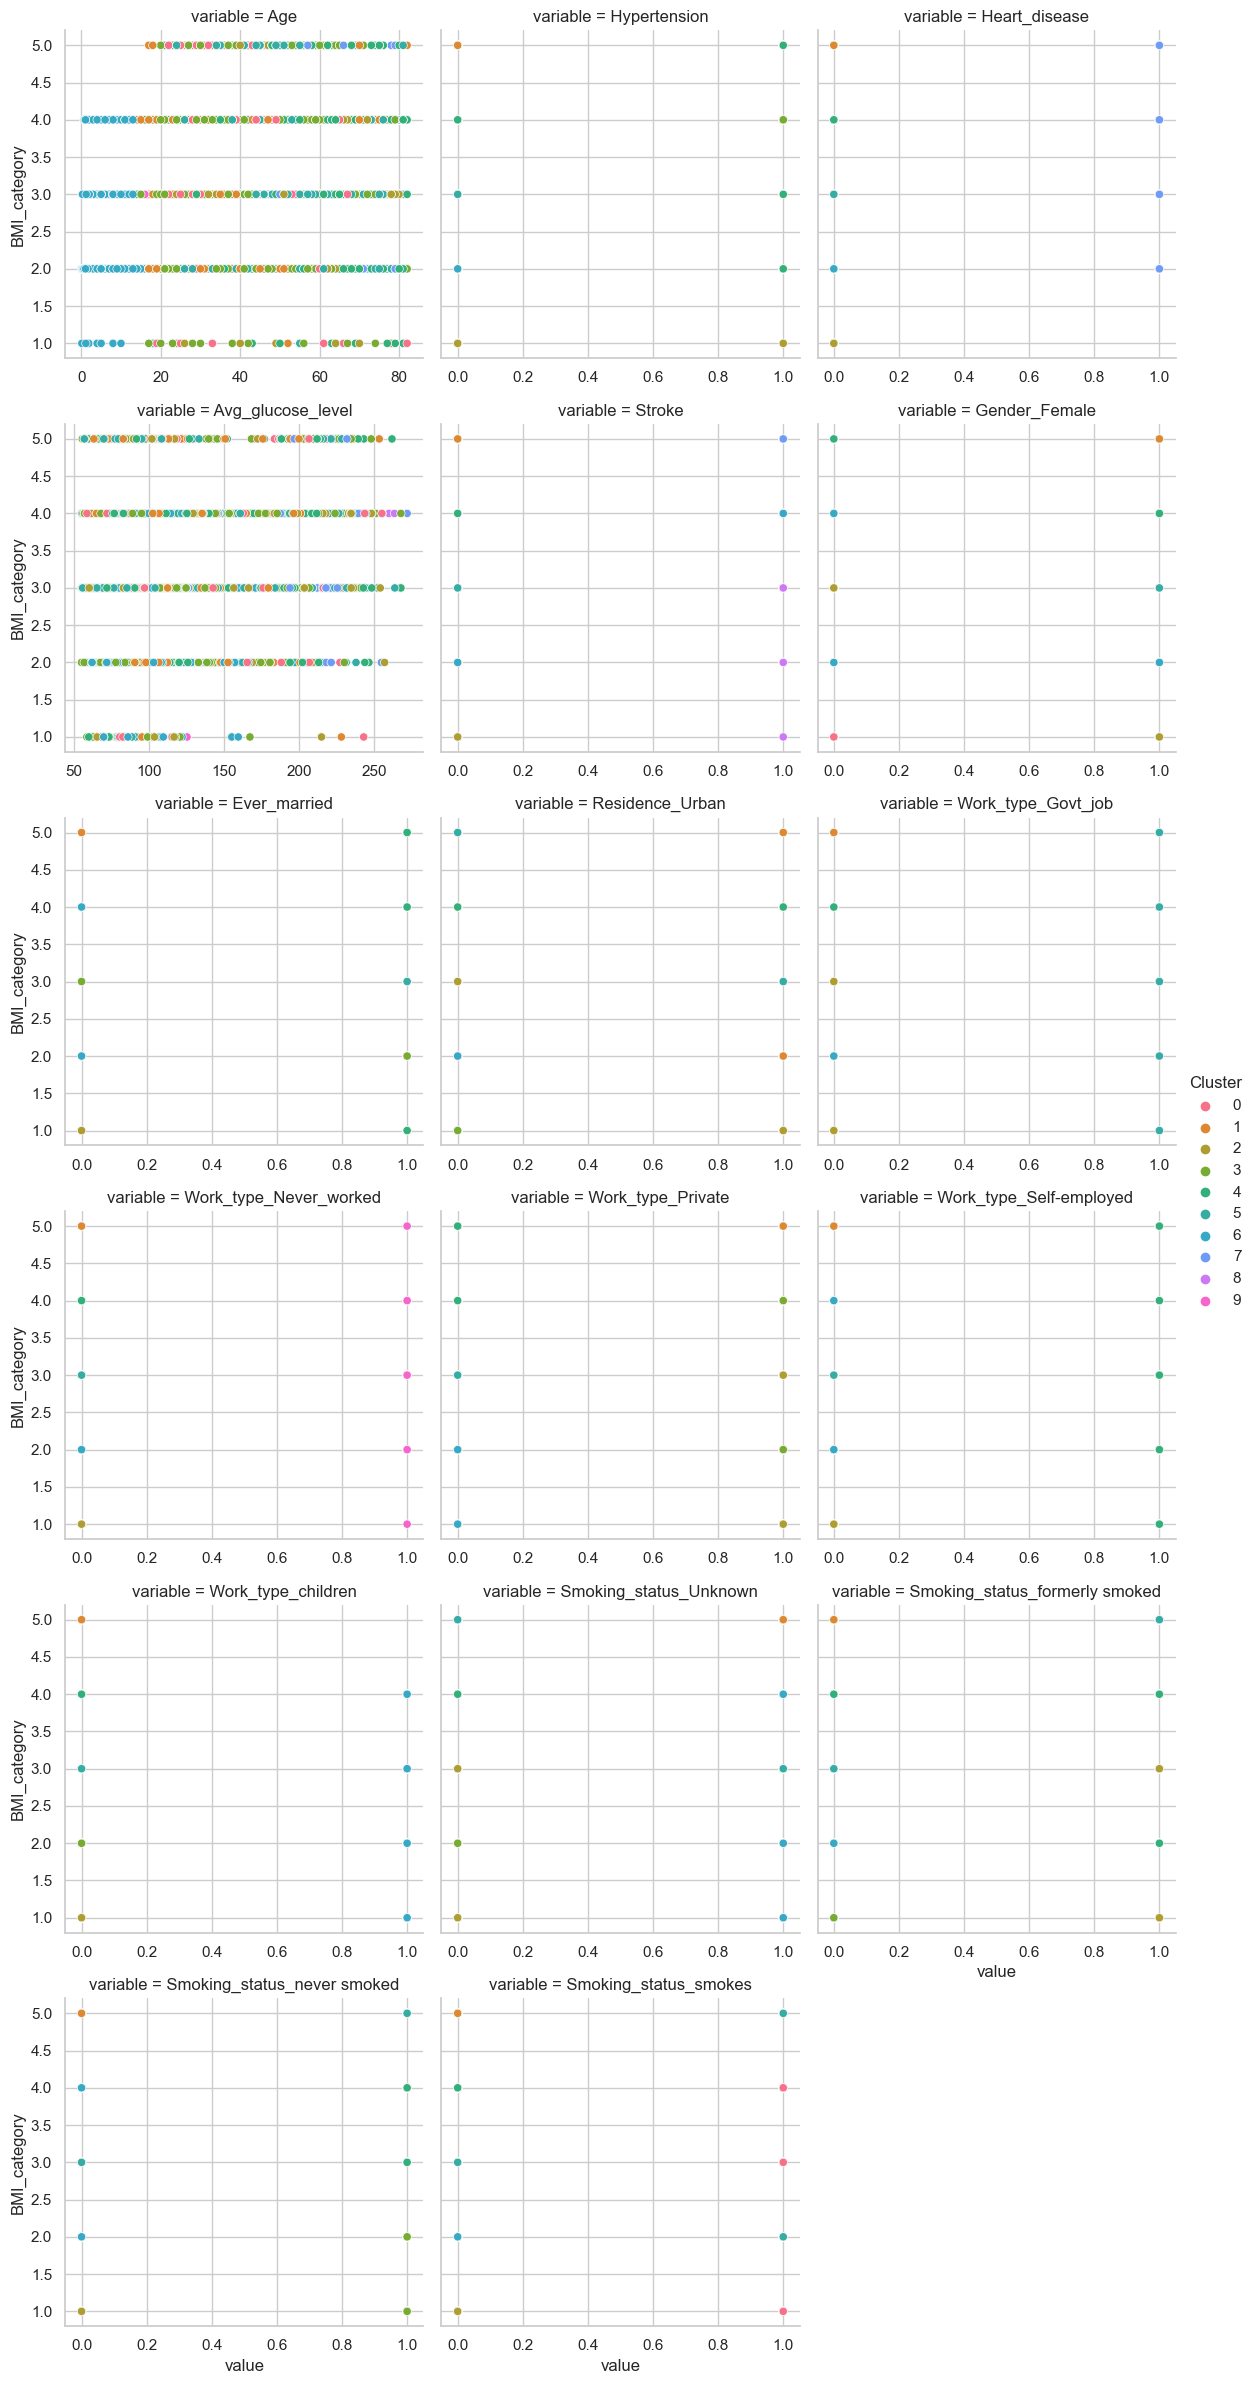

In [295]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["BMI_category"] = y
sns.relplot(
    x="value", 
    y="BMI_category", hue="Cluster", 
    col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(value_vars=df.columns, id_vars=["BMI_category", "Cluster"],),
)

In [254]:
stroke_data[stroke_data['Bmi'].isna()].shape

(201, 12)

In [184]:
stroke_data.shape

(5109, 11)

In [183]:
stroke_data[stroke_data['Bmi'].isna()]['Smoking_status'].value_counts()

never smoked       55
smokes             52
formerly smoked    48
Unknown            46
Name: Smoking_status, dtype: int64

In [185]:
stroke_data[stroke_data['Bmi'].isna()]['Stroke'].value_counts()

0    161
1     40
Name: Stroke, dtype: int64

In [186]:
stroke_data[~stroke_data['Bmi'].isna()]['Stroke'].value_counts()

0    4699
1     209
Name: Stroke, dtype: int64

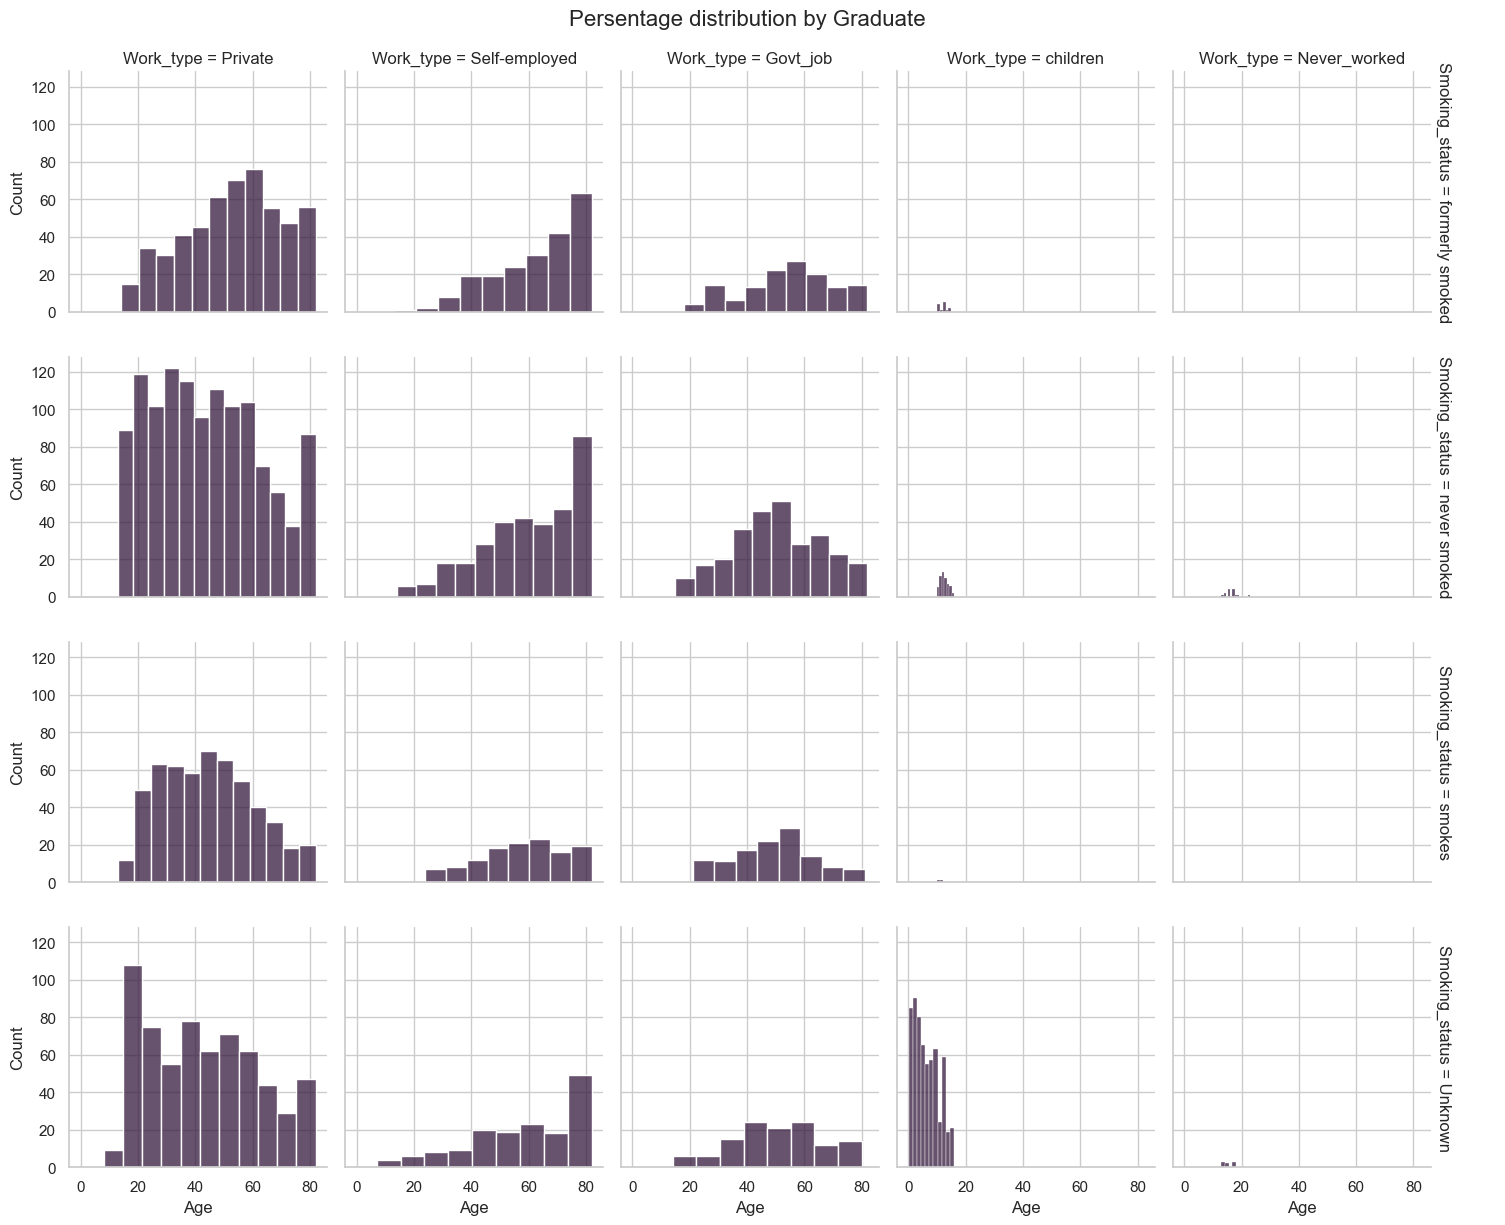

In [238]:
g = sns.FacetGrid(stroke_data, col="Work_type", row='Smoking_status', margin_titles=True)
g.map_dataframe(sns.histplot, x='Age', multiple="stack",
                common_norm=True, element='bars', stat='count')
g.add_legend()
g.figure.suptitle(f"Persentage distribution by Graduate", size=16, y=1.02)
plt.show()